Mounted at /content/gdrive
Dataset saved as /content/gdrive/My Drive/Projects/CustomerSegmentation/customer_segmentation_dataset.csv


<ipython-input-1-b6772ab4ba26>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalSpend'] = data['Quantity'] * data['UnitPrice']


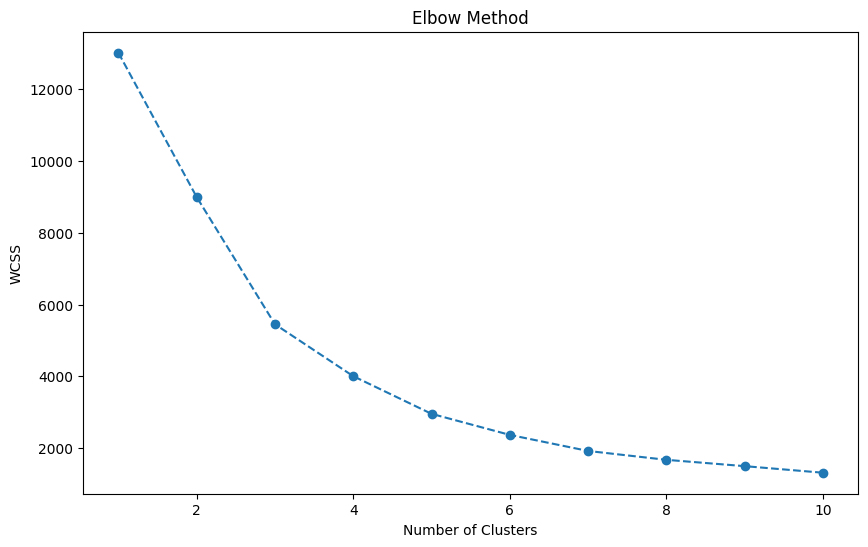

Silhouette Score: 0.6000
Davies-Bouldin Index: 0.5625


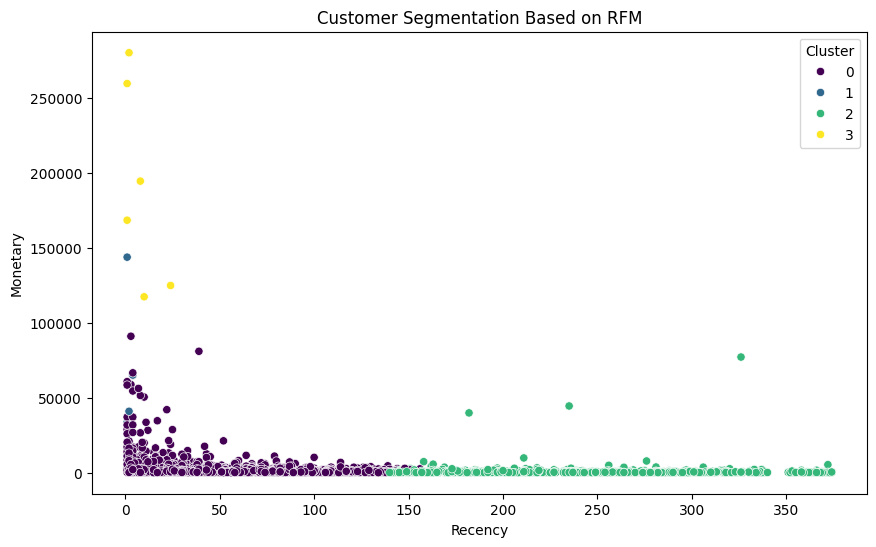

<ipython-input-1-b6772ab4ba26>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Monetary', data=rfm, palette='Set2')


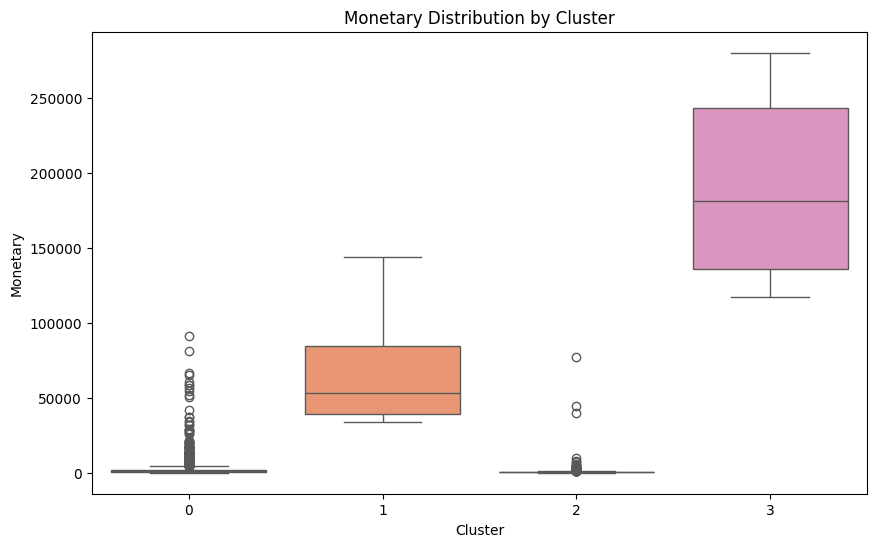

<ipython-input-1-b6772ab4ba26>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Frequency', data=rfm, palette='Set2')


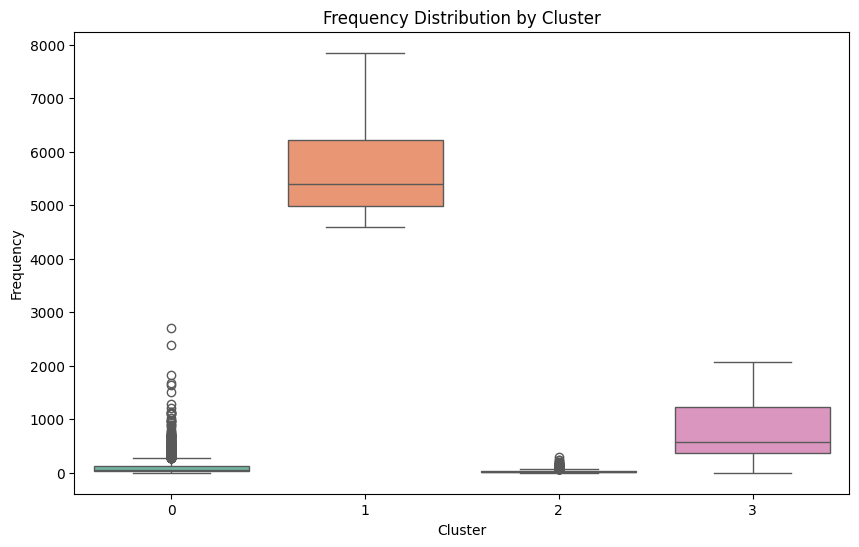

<ipython-input-1-b6772ab4ba26>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Recency', data=rfm, palette='Set2')


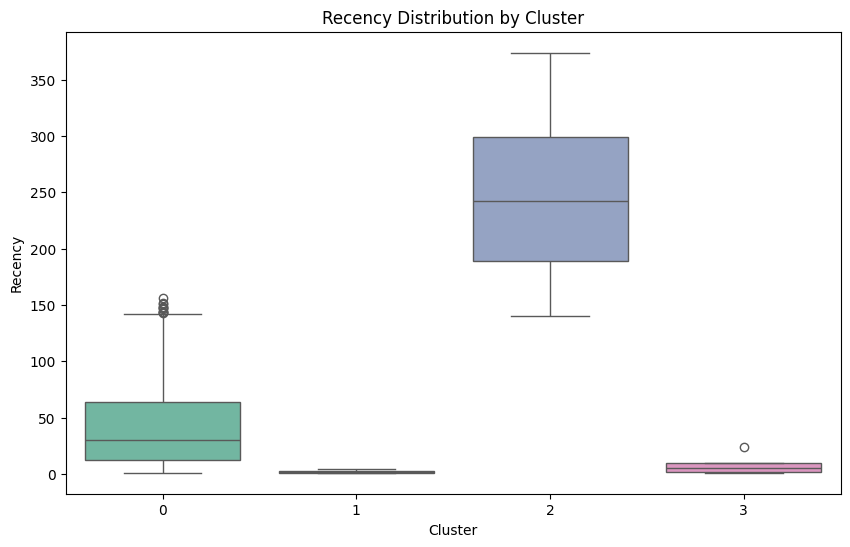

        Recency        Frequency           Monetary           
           mean median      mean  median       mean     median
Cluster                                                       
0         41.34   30.0    104.58    57.0    2091.82     922.46
1          2.00    1.5   5807.00  5393.0   70925.29   53078.18
2        247.31  242.5     27.79    18.0     637.32     310.15
3          7.67    5.0    826.83   572.5  190863.46  181511.64
            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         326          1  77183.60        2
12347.0           2        182   4310.00        0
12348.0          75         31   1797.24        0
12349.0          19         73   1757.55        0
12350.0         310         17    334.40        2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/gdrive')
absolute_path = '/content/gdrive/My Drive/Projects/CustomerSegmentation/'

# Function to transform Excel dataset to CSV
def transform_excel_to_csv(input_file, output_file):
    # Load Excel file
    excel_data = pd.ExcelFile(input_file)
    # Read the first sheet (assuming single sheet dataset)
    df = excel_data.parse(excel_data.sheet_names[0])
    # Save as CSV
    df.to_csv(output_file, index=False)
    print(f'Dataset saved as {output_file}')

# Transform Online Retail.xlsx to dataset.csv
transform_excel_to_csv(absolute_path + 'Online Retail.xlsx', absolute_path + 'customer_segmentation_dataset.csv')

# Load the dataset
data = pd.read_csv(absolute_path + 'customer_segmentation_dataset.csv')

# Data Cleaning
# Remove rows with missing values
data.dropna(inplace=True)

# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Remove rows with negative or zero quantities and prices
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

# Feature Engineering
# Calculate Total Spend per transaction
data['TotalSpend'] = data['Quantity'] * data['UnitPrice']

# RFM Analysis (Recency, Frequency, Monetary)
# Calculate Recency
snapshot_date = data['InvoiceDate'].max() + pd.DateOffset(days=1)
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # Recency
    'InvoiceNo': 'count',                                   # Frequency
    'TotalSpend': 'sum'                                     # Monetary
})
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalSpend': 'Monetary'}, inplace=True)

# Normalize the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Determine optimal number of clusters using Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means with optimal clusters (e.g., k=4)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Evaluate Clustering Performance
sil_score = silhouette_score(rfm_scaled, kmeans.labels_)
db_score = davies_bouldin_score(rfm_scaled, kmeans.labels_)

print(f'Silhouette Score: {sil_score:.4f}')
print(f'Davies-Bouldin Index: {db_score:.4f}')

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation Based on RFM')
plt.show()

# Boxplot for Monetary by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Monetary', data=rfm, palette='Set2')
plt.title('Monetary Distribution by Cluster')
plt.show()

# Boxplot for Frequency by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Frequency', data=rfm, palette='Set2')
plt.title('Frequency Distribution by Cluster')
plt.show()

# Boxplot for Recency by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Recency', data=rfm, palette='Set2')
plt.title('Recency Distribution by Cluster')
plt.show()

# Summary Table for Clusters
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median']
}).round(2)
print(cluster_summary)

# Save the segmented data and summary
rfm.to_csv(absolute_path + 'customer_segments.csv')
cluster_summary.to_csv(absolute_path + 'cluster_summary.csv')

print(rfm.head())

# Describe the dataset



In [2]:
import pandas as pd
from google.colab import drive

# Mount Google Drive to access files
drive.mount('/content/gdrive')
absolute_path = '/content/gdrive/My Drive/Projects/CustomerSegmentation/'

def describe_customer_segmentation(file_path):
    df = pd.read_csv(file_path)

    print("===== Dataset Info =====")
    print(df.info())

    print("\n===== First 5 Rows =====")
    print(df.head())

    print("\n===== Missing Values =====")
    print(df.isnull().sum())

    print("\n===== Descriptive Statistics (Numerical Columns) =====")
    print(df.describe())

    print("\n===== Descriptive Statistics (Categorical Columns) =====")
    categorical_columns = ['InvoiceNo', 'StockCode', 'Description', 'Country']
    for col in categorical_columns:
        if col in df.columns:
            print(f"\nTop 10 Most Frequent Values in '{col}':")
            print(df[col].value_counts().head(10))

    if 'CustomerID' in df.columns:
        print(f"\nUnique Customers: {df['CustomerID'].nunique()}")

    if 'InvoiceNo' in df.columns:
        print(f"Total Transactions: {df['InvoiceNo'].nunique()}")

describe_customer_segmentation(absolute_path + 'customer_segmentation_dataset.csv')

Mounted at /content/gdrive
===== Dataset Info =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

===== First 5 Rows =====
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNI